In [2]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.table import Table
import random as random
import itertools
import scipy.sparse as sparse



import numpy as np

In [3]:
board_rows=8
board_col=24
learning_rate = 0.6
discount_factor = 0.95

def fwd_board_maker(end_reward, blank_reward):
    board = np.zeros((board_rows,board_col))
    board[:,0:board_col-1] = blank_reward
    board[:,board_col-1]=end_reward
    return board

def litter_board_maker(litter_reward, blank_reward, end_reward):
    np.random.seed(1)
    rewards = (blank_reward, litter_reward )
    occurrence_probabilities = [0.9, 0.1]
    
    board=np.reshape([np.random.choice(rewards, p=occurrence_probabilities) for x in range(board_rows*board_col)], (board_rows,board_col))
    board[:,board_col-1] = end_reward
  
    return board

def grass_board_maker(grass_reward, blank_reward, end_reward):
    board = np.zeros((board_rows,board_col))
    board[1:7]=blank_reward
    board[0, :] = grass_reward
    board[7, : ] = grass_reward
    board[:,board_col-1] = end_reward
    return board

def obstc_board_maker(obstc_reward, blank_reward, end_reward):
    np.random.seed(7)
    rewards = (blank_reward, obstc_reward )
    occurrence_probabilities = [0.9, 0.1]
    
    board=np.reshape([np.random.choice(rewards, p=occurrence_probabilities) for x in range(board_rows*board_col)], (board_rows,board_col))
    board[:,board_col-1] = end_reward
  
    return board

def reward_matrix(board):
    c=0
    reward=np.zeros((board_rows,board_col,5))
    for i in range(board_rows):
        for j in range(board_col):
            if (i>=1):
                reward[i-1,j,2]=board[i,j] #Going down
                if(j>=1):
                    reward[i-1, j-1, 3] = board[i,j] #Going diag down
            if(j>=1):
                reward[i,j-1,0]=board[i,j] #Going right
            if(i<7):
                reward[i+1,j,1]=board[i,j] #Going up
                if(j>=1):
                    reward[i+1, j-1,4]=board[i,j] #Going diag up
    return reward

def Q_value_update(state_row, state_column, reward_matrix, eps, Q_matrix):
     
    
    directions = [0,1,2,3,4]      #("right", "up", "down", "diag down", "diag")
    
    # candidate next states
        
    right = Q_matrix[state_row, state_column, 0] #right
    up = Q_matrix[state_row, state_column, 1 ] #up
    down = Q_matrix[state_row, state_column, 2] #down
    diag_down = Q_matrix[state_row, state_column, 3] #diag down
    diag = Q_matrix[state_row,state_column, 4] #diag
    
    if (state_row <7 ) and (state_row != 0):
        next_state_candidates = {"up" : up, "down" : down, "right" : right, "diag_down" : diag_down, "diag" : diag}
        next_state_max_Q = max(next_state_candidates, key = next_state_candidates.get) #return a string telling next state direction
        
        if (next_state_max_Q == "right"):
            action = np.random.choice(directions, p = [1-eps, eps/4, eps/4, eps/4, eps/4])
        if (next_state_max_Q == "up"):
            action = np.random.choice(directions, p = [eps/4, 1-eps, eps/4, eps/4, eps/4])
        if (next_state_max_Q == "down"):
            action = np.random.choice(directions, p = [eps/4, eps/4, 1-eps, eps/4, eps/4])
        if (next_state_max_Q == "diag_down"):
            action = np.random.choice(directions, p = [eps/4, eps/4, eps/4, 1-eps, eps/4])
        if (next_state_max_Q == "diag"):
            action = np.random.choice(directions, p = [eps/4, eps/4, eps/4, eps/4, 1-eps])   
    
    if (state_row ==7 ) :
        next_state_candidates = {"up" :up,  "right" : right, "diag" : diag}
        next_state_max_Q = max(next_state_candidates, key = next_state_candidates.get) #return a string telling next state direction
        
        if (next_state_max_Q == "up"):
            action = np.random.choice(directions, p = [eps/2, 1-eps ,0, 0, eps/2])
        
        if (next_state_max_Q == "right"):
            action = np.random.choice(directions, p = [1-eps, eps/2, 0, 0, eps/2])
       
        if (next_state_max_Q == "diag"):
            action = np.random.choice(directions, p = [eps/2, eps/2, 0, 0, 1-eps])   

    if (state_row ==0 ) :
        next_state_candidates =  {"down" : down, "right" : right, "diag_down" : diag_down}
        
        next_state_max_Q = max(next_state_candidates, key = next_state_candidates.get) #return a string telling next state direction

        if (next_state_max_Q == "down"):
            action = np.random.choice(directions, p = [eps/2, 0, 1-eps, eps/2, 0])
        if (next_state_max_Q == "right"):
            action = np.random.choice(directions, p = [1-eps, 0, eps/2, eps/2, 0])
        if (next_state_max_Q == "diag_down"):
            action = np.random.choice(directions, p = [eps/2, 0, eps/2, 1-eps, 0])
        
    #choose next state (s') using epsilon greedy 
    
    if (action== 0):
        next_state_row = state_row 
        next_state_column = state_column+1
        next_action = 0 
    if (action== 1):
        next_state_row= state_row -1
        next_state_column = state_column 
        next_action = 1 
    if (action== 2):
        next_state_row = state_row + 1
        next_state_column = state_column 
        next_action = 2 
    if (action== 3):
        next_state_row = state_row + 1
        next_state_column= state_column + 1
        next_action = 3
    if (action== 4):
        next_state_row = state_row -1
        next_state_column = state_column +1
        next_action = 4 
   
    delta_Q = (reward_matrix[state_row,state_column,action] + discount_factor*max(Q_matrix[next_state_row, next_state_column, : ]) - Q_matrix[state_row,state_column, action] )
    Q_value = Q_matrix[state_row,state_column, action] + learning_rate * delta_Q
    Q_matrix[state_row, state_column, action] = Q_value
    
    reward_matrix[state_row,state_column,action]=-70
        
    return next_state_row, next_state_column, Q_matrix, reward_matrix



def learnQ_matrix (board):
    Q=np.zeros((board_rows, board_col, 5))
    
    for j in range(9000):
        reward=reward_matrix(board)
        path=np.zeros((board_rows, board_col))
        eps=1-(j/9000)
        np.random.seed(j)
        random_initial_row = np.random.choice(np.arange(board_rows-1))
        random_initial_column = np.random.choice(np.arange(board_col-1))
        next_state_row, next_state_column, Q, reward = Q_value_update(random_initial_row, random_initial_column,reward, eps, Q)
        
        while( next_state_column < 23):
                  next_state_row, next_state_column, Q, reward = Q_value_update(next_state_row, next_state_column,reward, eps, Q)
       
    return Q


def reducer(source_matrix):
    reduced_Q_matrix = np.empty((board_rows, board_col))

    for i in range(board_rows):
        for j in range(board_col):
            if (i==0):
                reduced_Q_matrix[i,j] = np.argmax(np.where(source_matrix[i,j]!=0, source_matrix[i,j], -1000))
            elif (i==7):
                reduced_Q_matrix[i,j] = np.argmax(np.where(source_matrix[i,j]!=0, source_matrix[i,j], -1000))
            else:
                reduced_Q_matrix[i,j] = np.argmax(source_matrix[i,j])

    return reduced_Q_matrix

 
def pathmaker(Q,board, row, col):
    Q=reducer(Q)
    path=np.zeros((board_rows, board_col))
    path[row,col]=1
    nrow = 0
    ncol = 0
    while (col<23):
        print(Q[row, col], row, col)
        if (Q[row, col]==0.):
            ncol = col+1
            nrow=row
        if (Q[row, col]==1.):
            nrow= row-1
            ncol=col
        if (Q[row, col]==2.):
            nrow = row + 1
            ncol=col
        if (Q[row, col]==3.):
            nrow = row + 1
            ncol= col + 1
        if (Q[row, col]==4.):
            nrow = row-1
            ncol = col+1   
        path[nrow,ncol]=1
        col=ncol
        row=nrow
    
    return path




2.0 0 0
3.0 1 0
0.0 2 1
3.0 2 2
0.0 3 3
4.0 3 4
3.0 2 5
4.0 3 6
4.0 2 7
3.0 1 8
3.0 2 9
3.0 3 10
0.0 4 11
0.0 4 12
0.0 4 13
4.0 4 14
3.0 3 15
4.0 4 16
0.0 3 17
0.0 3 18
4.0 3 19
1.0 2 20
4.0 1 20
3.0 0 21
2.0 1 22
0.0 2 22


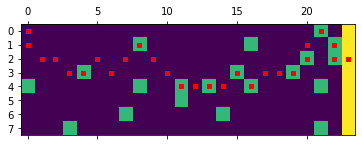

In [12]:
litter=litter_board_maker(5, -1, 8)
Qlitt=learnQ_matrix(litter)

plt.imshow(litter)
plt.spy(pathmaker(Qlitt, litter, 0, 0), markersize=4, color='red')

0.0 0 0
0.0 0 1
0.0 0 2
0.0 0 3
0.0 0 4
0.0 0 5
0.0 0 6
0.0 0 7
0.0 0 8
0.0 0 9
0.0 0 10
0.0 0 11
0.0 0 12
0.0 0 13
0.0 0 14
0.0 0 15
0.0 0 16
0.0 0 17
0.0 0 18
0.0 0 19
0.0 0 20
0.0 0 21
0.0 0 22


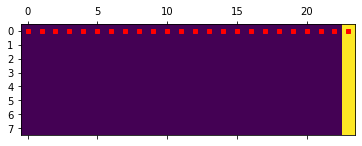

In [5]:
fwd=fwd_board_maker(5,-1)
Qfwd=learnQ_matrix(fwd)
plt.imshow(fwd)
plt.spy(pathmaker(Qfwd, fwd, 0, 0), markersize=4, color='red')

3.0 0 4
0.0 1 5
0.0 1 6
0.0 1 7
0.0 1 8
0.0 1 9
0.0 1 10
0.0 1 11
0.0 1 12
0.0 1 13
0.0 1 14
0.0 1 15
0.0 1 16
0.0 1 17
0.0 1 18
0.0 1 19
0.0 1 20
0.0 1 21
0.0 1 22


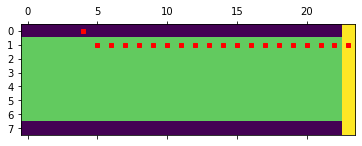

In [6]:
grass=grass_board_maker(-20, -1, 5)
Qgrass=learnQ_matrix(grass)
plt.imshow(grass)
plt.spy(pathmaker(Qgrass, grass, 0, 4), markersize=4, color='red')

1.0 3 3
4.0 2 3
4.0 1 4
0.0 0 5
0.0 0 6
0.0 0 7
0.0 0 8
0.0 0 9
0.0 0 10
0.0 0 11
0.0 0 12
0.0 0 13
3.0 0 14
4.0 1 15
0.0 0 16
3.0 0 17
0.0 1 18
0.0 1 19
0.0 1 20
0.0 1 21
0.0 1 22


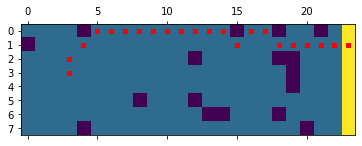

In [7]:
obstc=obstc_board_maker(-10,-3, 10)
Qobstc=learnQ_matrix(obstc)
plt.imshow(obstc)
plt.spy(pathmaker(Qobstc, obstc, 3, 3), markersize=4, color='red')

0.0 3 3
3.0 3 4
3.0 4 5
3.0 5 6
0.0 6 7
0.0 6 8
4.0 6 9
4.0 5 10
4.0 4 11
3.0 3 12
4.0 4 13
0.0 3 14
3.0 3 15
4.0 4 16
3.0 3 17
4.0 4 18
4.0 3 19
4.0 2 20
0.0 1 21
2.0 1 22
0.0 2 22


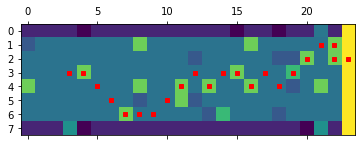

In [8]:
combined=litter+grass+obstc
Qcombine=learnQ_matrix(combined)
plt.imshow(combined)
plt.spy(pathmaker(Qcombine, combined, 3, 3), markersize=4, color='red')

3.0 0 3
3.0 1 4
3.0 2 5
3.0 3 6
0.0 4 7
0.0 4 8
4.0 4 9
3.0 3 10
4.0 4 11
3.0 3 12
4.0 4 13
0.0 3 14
3.0 3 15
4.0 4 16
3.0 3 17
4.0 4 18
4.0 3 19
4.0 2 20
0.0 1 21
2.0 1 22
0.0 2 22


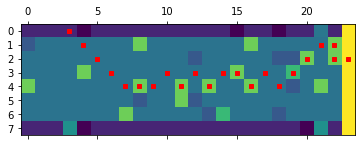

In [10]:
plt.imshow(combined)
plt.spy(pathmaker(Qcombine, combined, 0, 3), markersize=4, color='red')

In [28]:
print(reducer(Qobstc))
print(obstc)
print(reducer(Qfwd))
print(reducer(Qgrass))
print(reducer(Qlitt))

[[0. 0. 0. 2. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 2. 0. 0. 3. 0. 0. 3. 0. 0. 0.]
 [1. 1. 1. 1. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 1. 0. 0. 0. 0. 0. 0. 0.]
 [4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 4. 4. 0. 0. 0. 0. 0.]
 [4. 4. 4. 1. 1. 1. 1. 1. 1. 1. 1. 1. 4. 1. 1. 0. 0. 3. 2. 0. 0. 0. 0. 0.]
 [2. 3. 2. 2. 2. 2. 2. 2. 3. 2. 2. 2. 0. 3. 2. 0. 0. 0. 3. 0. 0. 0. 0. 0.]
 [2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 0. 3. 2. 0. 0. 0. 0. 0. 0. 0. 0.]
 [3. 2. 2. 2. 3. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 2. 3. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 4. 0. 0. 0. 0.]]
[[-1 -1 -1 -1 -5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -5 -1 -1 -5 -1 -1 -5 -1  5]
 [-5 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1  5]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -5 -1 -1 -1 -1 -1 -5 -5 -1 -1 -1  5]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -5 -1 -1 -1  5]
 [-1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -1 -5 -1 -1 -1  5]
 [-1 -1 -1 -1 -1 -1 -1 -

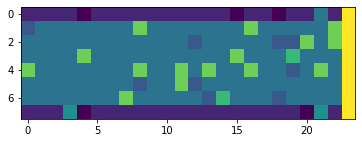

In [13]:
plt.imshow(combined)


In [27]:
Qlitt[0,0]

array([-2.        ,  0.        , -3.59998825, -3.59995975,  0.        ])

In [162]:
Qfwd=learnQ_matrix(fwd)
